In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
print("ori train ", poi_train_x.shape[0])
poi_train_x = np.matrix(poi_train_x.to_numpy())
print("matrix train ", len(poi_train_x))
poi_train_y = pd.read_csv('train_y.csv')
print("ori train y ", poi_train_y.shape[0])
poi_train_y = poi_train_y['Life Expectancy'].tolist()
print("matrix train y ", len(poi_train_y))
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

print (poi_train_x[0])
print (poi_train_y[0])

# num of poisoning points
poison_ct = 300
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

ori train  1319
matrix train  1319
ori train y  1319
matrix train y  1319
[[2.00900000e+03 0.00000000e+00 2.52077562e-01 2.22222222e-03
  1.14221725e-01 6.87422107e-04 9.79591837e-01 9.89711711e-05
  2.10892236e-01 1.60000000e-03 9.79166667e-01 1.74114916e-01
  9.79381443e-01 0.00000000e+00 1.80413125e-03 1.54066216e-05
  5.50724638e-01 5.36842105e-01 7.75316456e-01 6.47342995e-01]]
0.6736242884250474
Posion count:  300  Train count:  1319  Test count:  165  Proportion of poisoning:  0.1852995676343422


# Inverse Flip & Elastic Network Poisoner

y_opp [0. 0. 0. ... 0. 0. 0.]
stats [0. 0. 0. ... 0. 0. 0.]
total_prob 132.78026565464893
x_pois len:  300
x_pois col ct: 20
y_pois len:  300
classifier:  ElasticNetCV(max_iter=10000)
***************************
**** Poison Count:  51  ****
***************************
Iteration  0 
Objective Value:  -0.6587525965519364  Change:  -0.6587525965519364
Validation MSE  0.005554750575261518 
Test MSE  0.007356519150220884
 
Iteration  1
Objective Value: 0.02781074125936949  Difference:  0.6865633378113059
 
Iteration  2
Objective Value: 0.027810741259372638  Difference:  3.146788385421928e-15
 
Iteration  3
Objective Value: 0.027810741259375275  Difference:  2.6367796834847468e-15
 
Iteration  4
Objective Value: 0.02781074125937748  Difference:  2.2065682614424986e-15
 
Iteration  5
Objective Value: 0.027810741259379324  Difference:  1.842276331487369e-15
 
(51, 20) (1319, 20)
x_pois_result len:  51 , y_pois_result len:  51 , x_poised len:  1370 , y_poised len:  1370
classifier_poised  Elast

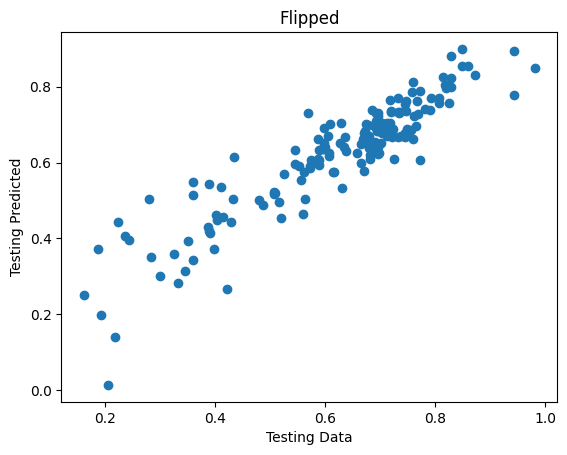

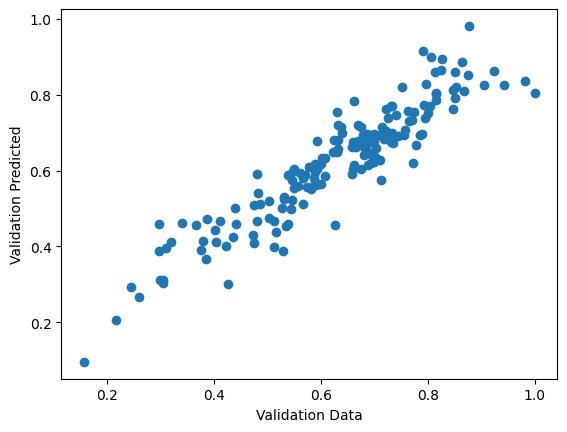

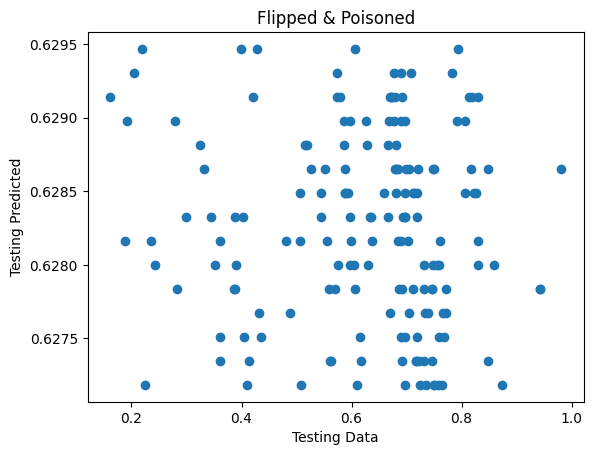

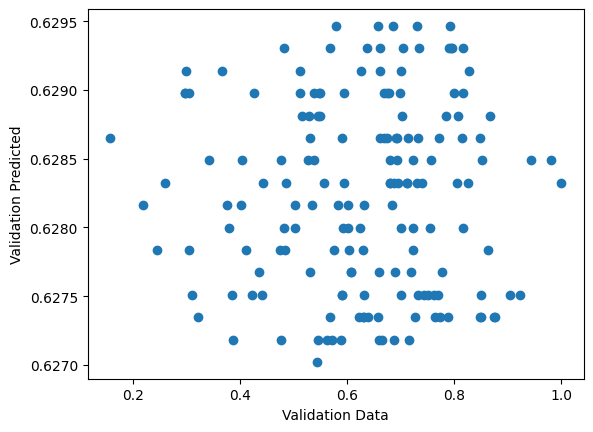

***************************
**** Poison Count:  106  ****
***************************
Iteration  0 
Objective Value:  -0.18922085107551884  Change:  -0.18922085107551884
Validation MSE  0.01536523059471564 
Test MSE  0.018433295540127976
 
Iteration  1
Objective Value: 0.027792425630750964  Difference:  0.2170132767062698
 
Iteration  2
Objective Value: 0.027792425630750964  Difference:  0.0
 
Iteration  3
Objective Value: 0.027792425630750964  Difference:  0.0
 
Iteration  4
Objective Value: 0.027792425630750964  Difference:  0.0
 
Iteration  5
Objective Value: 0.027792425630750964  Difference:  0.0
 
(106, 20) (1319, 20)
x_pois_result len:  106 , y_pois_result len:  106 , x_poised len:  1425 , y_poised len:  1425
classifier_poised  ElasticNetCV(max_iter=10000) , classifier2  ElasticNetCV(max_iter=10000)
 


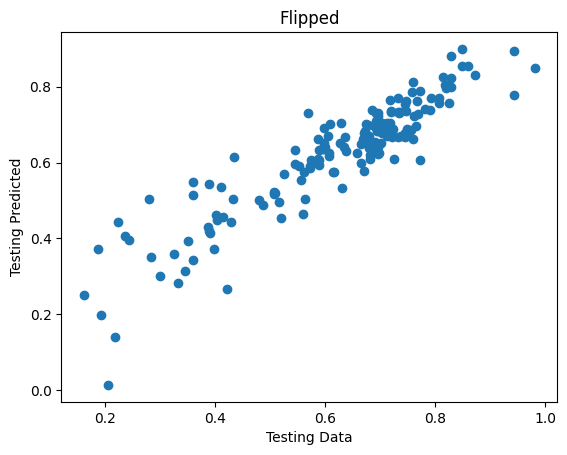

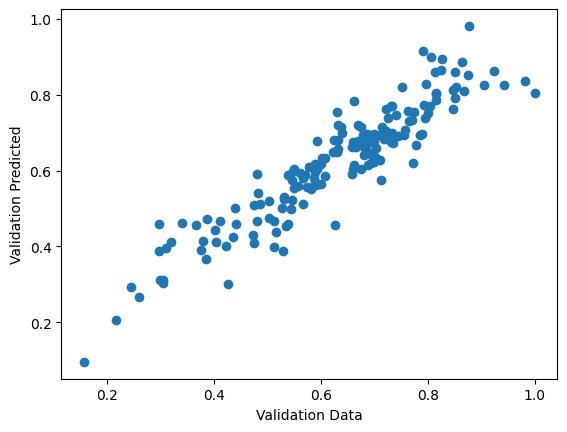

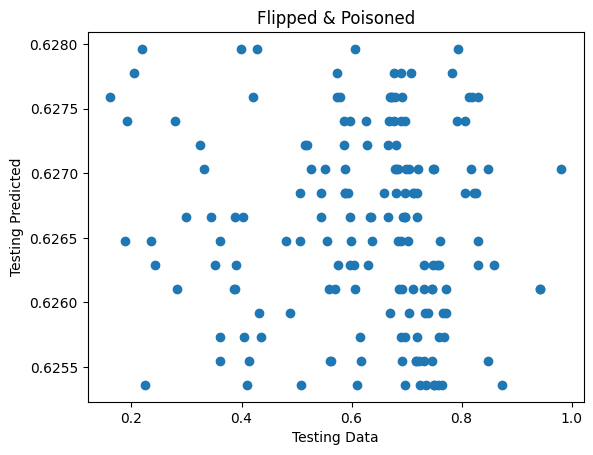

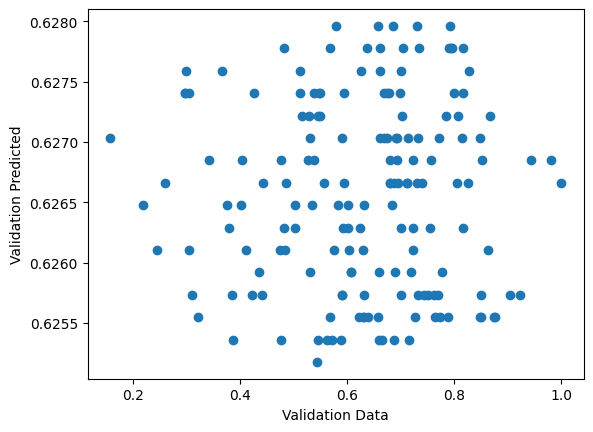

***************************
**** Poison Count:  165  ****
***************************
Iteration  0 
Objective Value:  0.02792068135128406  Change:  0.02792068135128406
Validation MSE  0.028185556587261882 
Test MSE  0.030325295110148764
 
Iteration  1
Objective Value: 0.027792583106235107  Difference:  -0.00012809824504895345
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.027792518104222525  Difference:  -0.000128163247061535
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.027792475853083618  Difference:  -0.000128205498200442
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.027792448389914813  Difference:  -0.00012823296136924706
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.027792430538885308  Difference:  -0.00012825081239875233
NO PROGRESS MADE!
 
(165, 20) (1319, 20)
x_pois_result len:  165 , y_pois_result len:  165 , x_poised len:  1484 , y_poised len:  1484
classifier_poised  ElasticNetCV(max_iter=10000) , classifier2  ElasticNetCV(max_iter=10000)
 


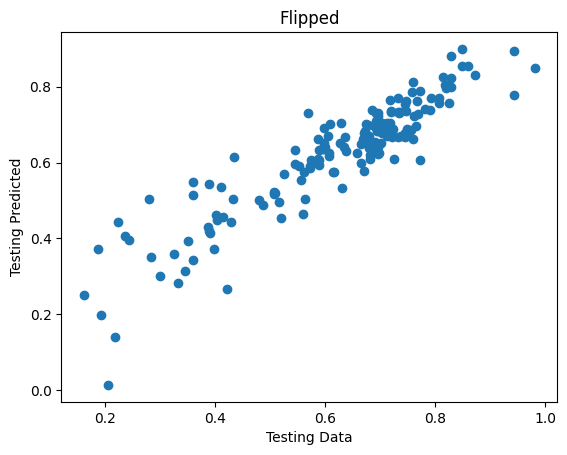

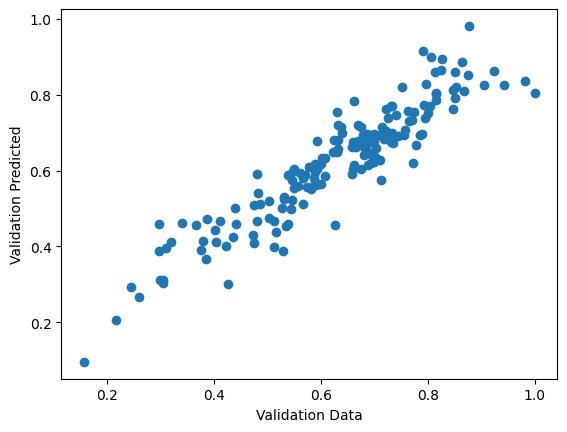

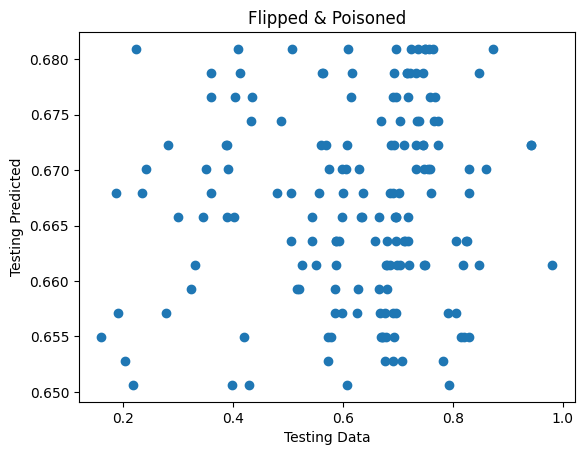

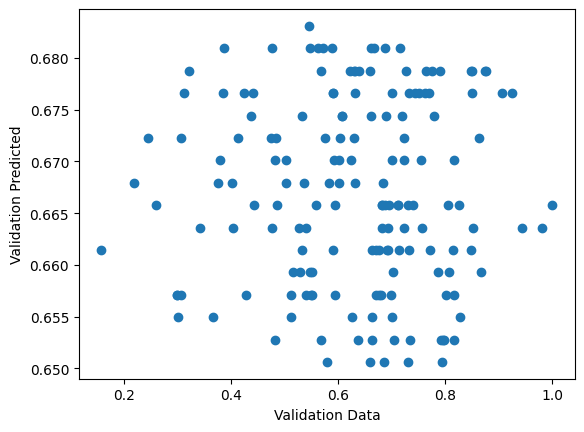

***************************
**** Poison Count:  230  ****
***************************
Iteration  0 
Objective Value:  0.029256472539117853  Change:  0.029256472539117853
Validation MSE  0.02943900648526887 
Test MSE  0.031767460725445854
 
Iteration  1
Objective Value: 0.027792740569113458  Difference:  -0.0014637319700043956
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.02779273949307217  Difference:  -0.001463733046045683
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.027792738793645414  Difference:  -0.001463733745472439
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.0277927383390181  Difference:  -0.001463734200099754
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.027792738043510377  Difference:  -0.0014637344956074765
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.027792737851430327  Difference:  -0.0014637346876875262
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.0277927377265783  Difference:  -0.0014637348125395543
NO PROGRESS MADE!
 
Iteration  8

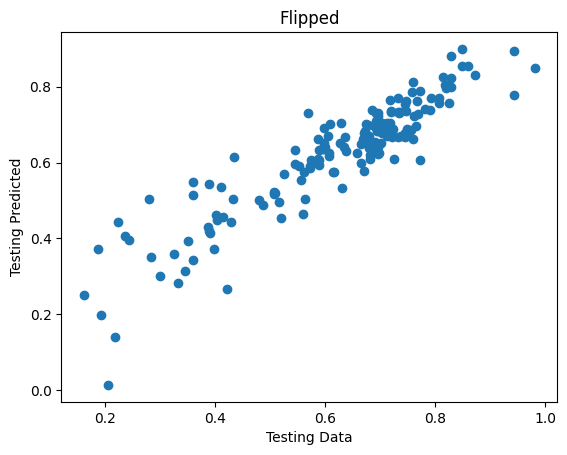

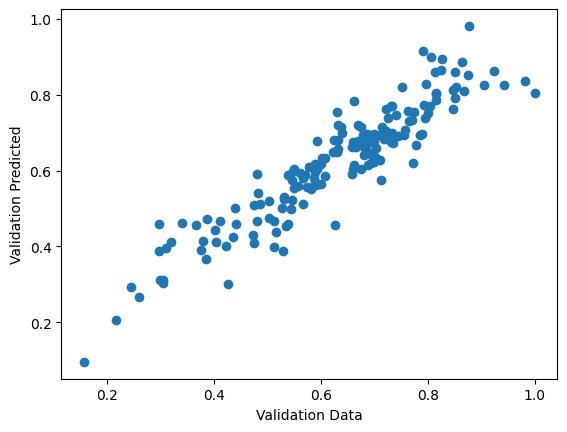

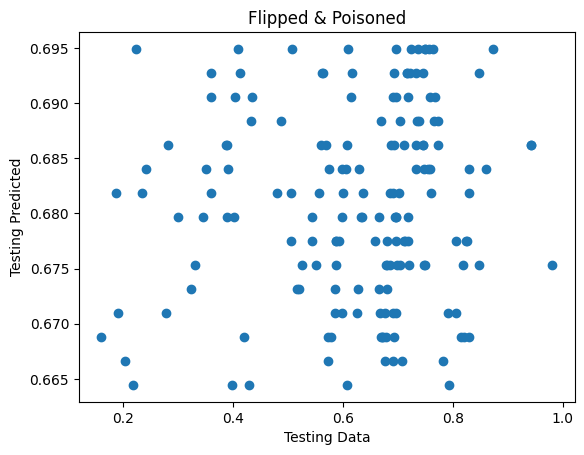

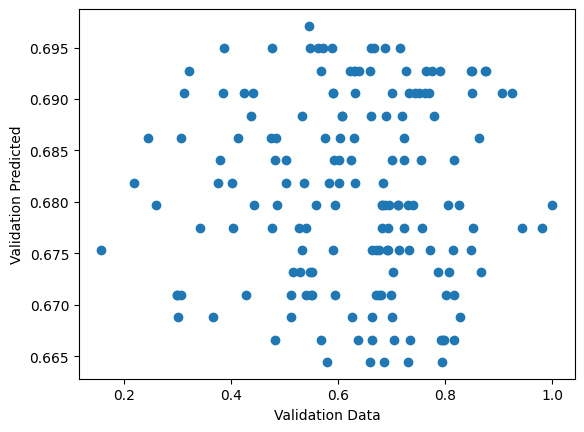

***************************
**** Poison Count:  300  ****
***************************
Iteration  0 
Objective Value:  0.031341131894508135  Change:  0.031341131894508135
Validation MSE  0.031054482583307987 
Test MSE  0.033639290983452766
 
Iteration  1
Objective Value: 0.027793849945386175  Difference:  -0.003547281949121961
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.027793849945386143  Difference:  -0.003547281949121992
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.027793849945386122  Difference:  -0.003547281949122013
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.027793849945386122  Difference:  -0.003547281949122013
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.027793849945386116  Difference:  -0.00354728194912202
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.027793849945386112  Difference:  -0.0035472819491220234
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.027793849945386105  Difference:  -0.0035472819491220303
NO PROGRESS MADE!
 
Iteration

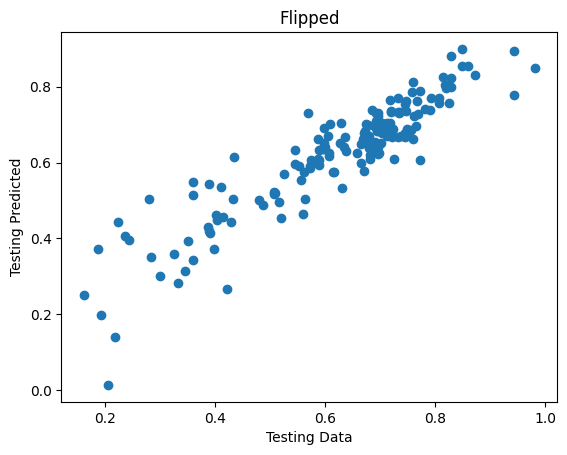

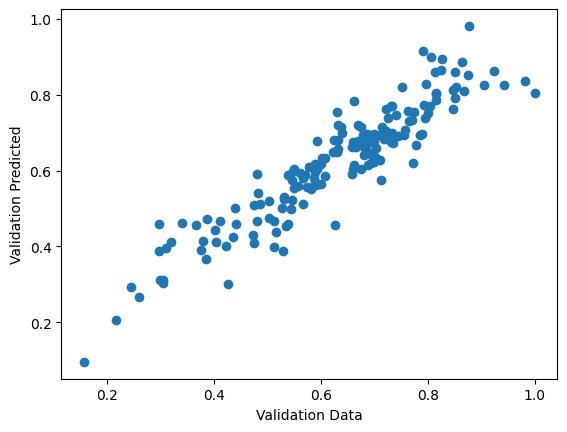

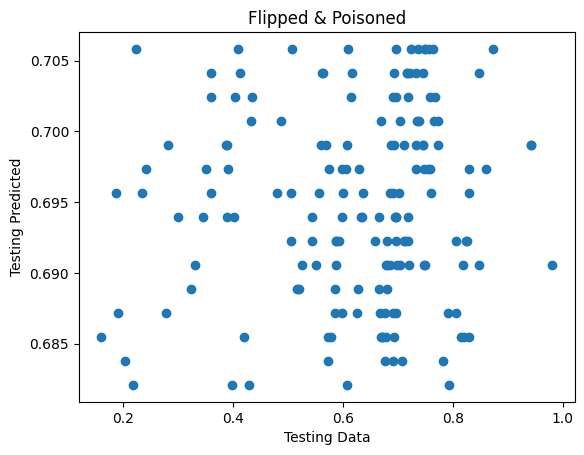

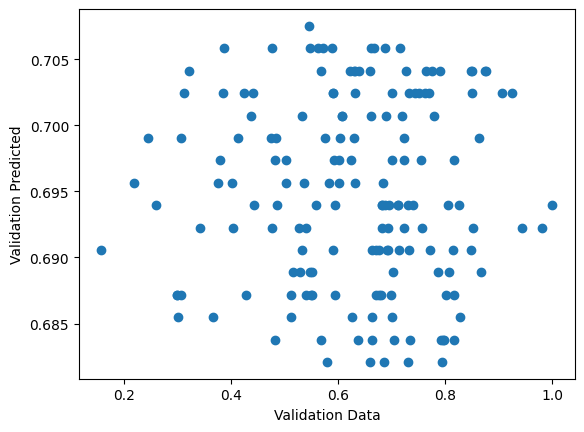


After Flipping, Unpoisoned 
 Validation MSE:  0.0037623749723120934 
 Test MSE: 0.0047619349297774605

After Flipping & Poisoning:
 Validation MSE:  0.031054482583307987 
 Test MSE: 0.033639290983452766


In [3]:
# flip the data
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.e_net_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,5,10)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Elastic Network Poisoner

In [4]:
# flip the data
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.e_net_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,5,10)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

classifier:  ElasticNetCV(max_iter=10000)
***************************
**** Poison Count:  51  ****
***************************
Iteration  0 
Objective Value:  -0.8819577510123437  Change:  -0.8819577510123437
Validation MSE  0.0044893839910476975 
Test MSE  0.00558518540237374
 
Iteration  1
Objective Value: 0.027773524352965356  Difference:  0.9097312753653091
 
Iteration  2
Objective Value: 0.027773760091621608  Difference:  2.3573865625195478e-07
 
Iteration  3
Objective Value: 0.0277737600919599  Difference:  3.382918944971891e-13
 


KeyboardInterrupt: 